# Сессионное задание. Классическое машинное обучение

### Научная и практическая значимость
Современные задачи ядерной энергетики, радиационного контроля, фундаментальной и прикладной физики требуют высокоточной регистрации и анализа излучения различной природы. Важной составляющей этих задач является возможность отделения компонентов ионизирующего излучения, таких как гамма-кванты и нейтроны, в условиях сложного фонового окружения.

Сцинтилляционные детекторы, особенно основанные на органических кристаллах (например, паратерфенил), обладают высокой чувствительностью к подобным видам излучения и активно применяются:

- при контроле состояния отработанного ядерного топлива,
- в системах радиационного мониторинга,
- в физических экспериментах по регистрации антинейтрино и редких событий,
- в медицине и промышленности.
Однако автоматическая классификация сигналов, поступающих с таких детекторов, представляет собой нетривиальную задачу, так как сигналы могут перекрываться, иметь сложную форму, шумы и вариации. Вручную такие объёмы данных (десятки тысяч сигналов) анализировать практически невозможно.

Применение методов машинного обучения, в частности кластеризации, позволяет:

- автоматизировать процесс распознавания сигналов разного типа,
- улучшить точность и стабильность выделения физических компонент,
- выявлять аномальные сигналы и потенциальные неисправности в системе регистрации,
- заложить основу для онлайн-анализа в реальном времени без участия оператора.

Разработка и тестирование эффективных алгоритмов кластеризации в данной области напрямую способствует:

- повышению точности научных измерений,
- улучшению качества систем радиационного контроля и безопасности,
- развитию технологий интеллектуальной обработки сигналов в ядерной и экспериментальной физике.

### Описание
Целью данной работы является автоматическая кластеризация сигналов, полученных со сцинтилляционного детектора, на основе их параметров. Необходимо разделить 23 479 сигналов на три кластера: два из них соответствуют различным типам частиц (гамма-кванты и нейтроны), а третий — группе аномальных или неидентифицируемых сигналов.
Задача решается методами машинного обучения без учителя с последующей интерпретацией результатов кластеризации.

### Исходные данные
Набор сигналов, каждый из которых описывается вектором признаков (характеристики сигнала: временные параметры, амплитудные показатели, статистические и производные метрики).

### Задача
Кластеризовать сигналы на три кластера:

- Кластер 0 — сигналы, соответствующие первому типу частиц (гамма-кванты или нейтроны),
- Кластер 1 — сигналы, соответствующие второму типу частиц,
- Кластер 2 — сигналы, не поддающиеся однозначной классификации (аномальные, смешанные или выбросы).

In [1]:
!pip install opendatasets --quiet

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [3]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/competitions/scintillation-detector'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anastasiays
Your Kaggle Key: ··········


100%|██████████| 13.2M/13.2M [00:00<00:00, 507MB/s]


Extracting archive ./scintillation-detector/scintillation-detector.zip to ./scintillation-detector


### Иследование и анализ датасета

In [4]:
dataset = pd.read_csv('scintillation-detector/Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,500,501,502,503,504
0,2890276,357,113,500,14820,14823,14824,14822,14818,14820,...,14822,14815,14815,14817,14819,14820,14822,14820,14819,NaN
1,4928764,740,359,500,14820,14822,14820,14826,14824,14822,...,14817,14824,14822,14824,14819,14820,14819,14822,14820,NaN
2,9630204,162,499,500,14820,14820,14822,14825,14820,14824,...,14821,14820,14820,14818,14821,14823,14820,14820,14821,NaN
3,15798632,841,123,500,14828,14822,14818,14824,14824,14822,...,14826,14822,14821,14820,14828,14820,14822,14823,14822,NaN
4,20637296,412,348,500,14823,14815,14823,14821,14827,14820,...,14820,14823,14828,14824,14820,14824,14824,14822,14825,NaN


In [5]:
dataset.isna().sum()

,0
0,0
1,0
2,0
3,0
4,0
...,...
500,0
501,0
502,0
503,0


In [6]:
# Удаляем колонки с нулями
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))

In [7]:
dataset.shape

(23479, 500)

In [8]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


In [9]:
dataset.describe()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
count,23479.000000,23479.000000,23479.000000,23479.000000,23479.000000,23479.000000,23479.000000,23479.000000,23479.000000,23479.000000,...,23479.000000,23479.000000,23479.000000,23479.000000,23479.000000,23479.000000,23479.000000,23479.000000,23479.000000,23479.000000
mean,14822.972316,14822.958474,14822.970016,14822.989991,14823.003961,14822.978619,14822.968610,14822.954470,14822.963670,14822.968908,...,14822.329017,14822.315686,14822.272073,14822.171728,14822.257123,14822.317092,14822.279399,14822.278163,14822.287789,14822.283743
std,2.805884,2.833516,2.840755,2.852066,2.833412,2.836271,2.831241,2.827526,2.846291,2.814655,...,3.357997,3.373568,3.340707,3.332547,3.290301,3.232245,3.268458,3.251192,3.253340,3.242307
min,14812.000000,14812.000000,14812.000000,14811.000000,14812.000000,14812.000000,14812.000000,14811.000000,14812.000000,14809.000000,...,14800.000000,14798.000000,14802.000000,14796.000000,14802.000000,14801.000000,14798.000000,14804.000000,14800.000000,14802.000000
25%,14821.000000,14821.000000,14821.000000,14821.000000,14821.000000,14821.000000,14821.000000,14821.000000,14821.000000,14821.000000,...,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000
50%,14823.000000,14823.000000,14823.000000,14823.000000,14823.000000,14823.000000,14823.000000,14823.000000,14823.000000,14823.000000,...,14823.000000,14823.000000,14823.000000,14822.000000,14823.000000,14823.000000,14823.000000,14823.000000,14823.000000,14823.000000
75%,14824.000000,14824.000000,14825.000000,14825.000000,14825.000000,14824.000000,14824.000000,14824.000000,14824.000000,14824.000000,...,14824.000000,14824.000000,14824.000000,14824.000000,14824.000000,14824.000000,14824.000000,14824.000000,14824.000000,14824.000000
max,14834.000000,14835.000000,14834.000000,14835.000000,14834.000000,14835.000000,14835.000000,14833.000000,14834.000000,14834.000000,...,14836.000000,14835.000000,14834.000000,14836.000000,14833.000000,14834.000000,14833.000000,14834.000000,14833.000000,14835.000000


Text(0, 0.5, 'bit ADC')

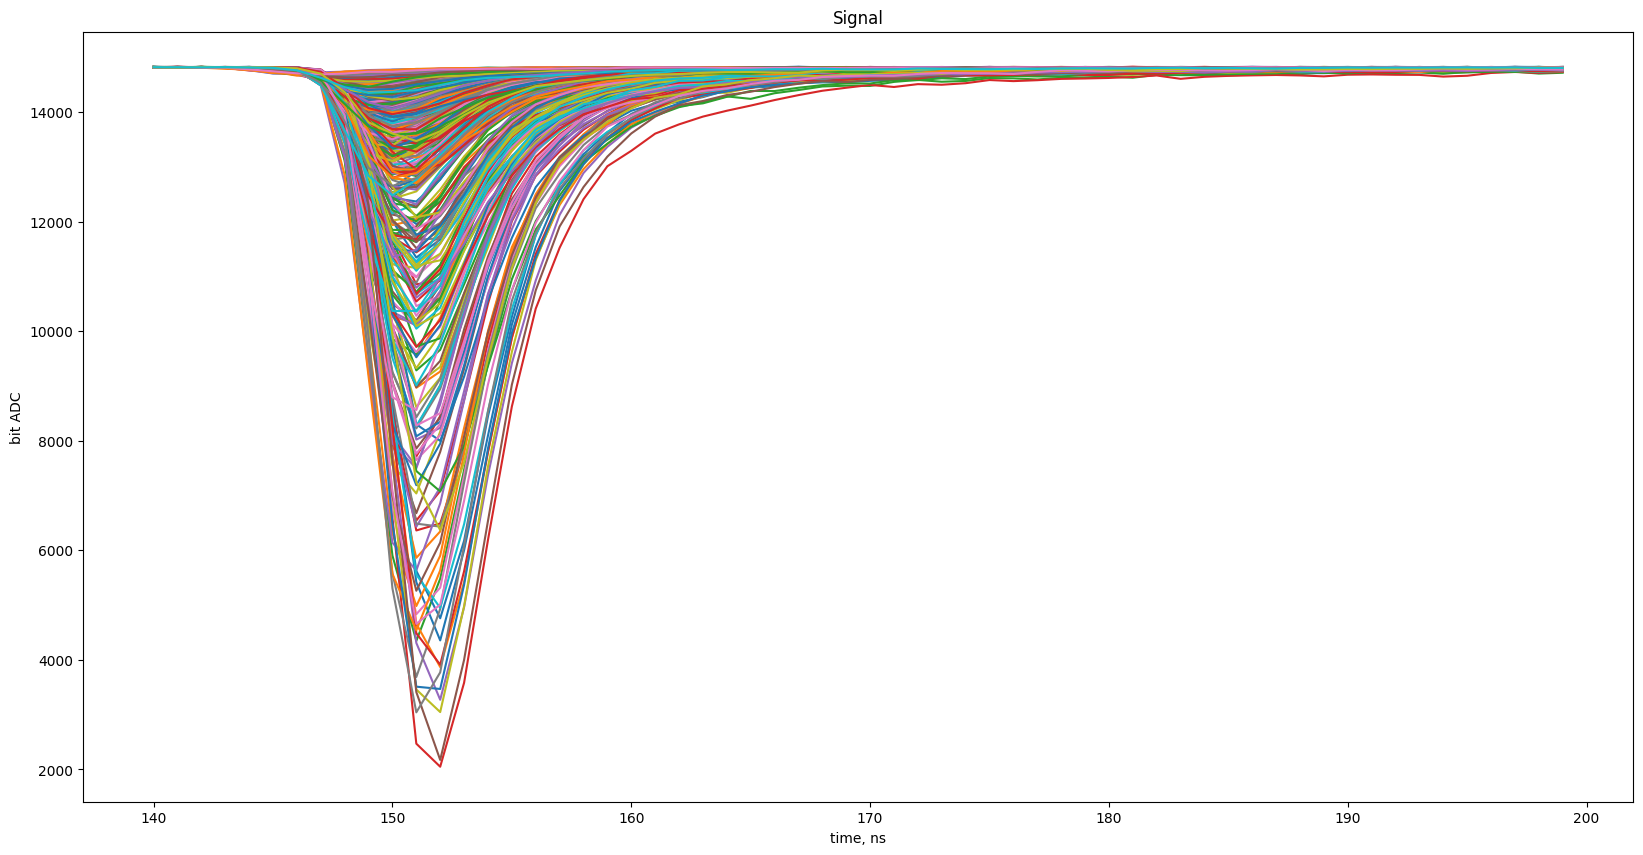

In [ ]:
# Отобразим сигналы
N=range(0,500)
ax = dataset.T[N][140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Text(0, 0.5, 'bit ADC')

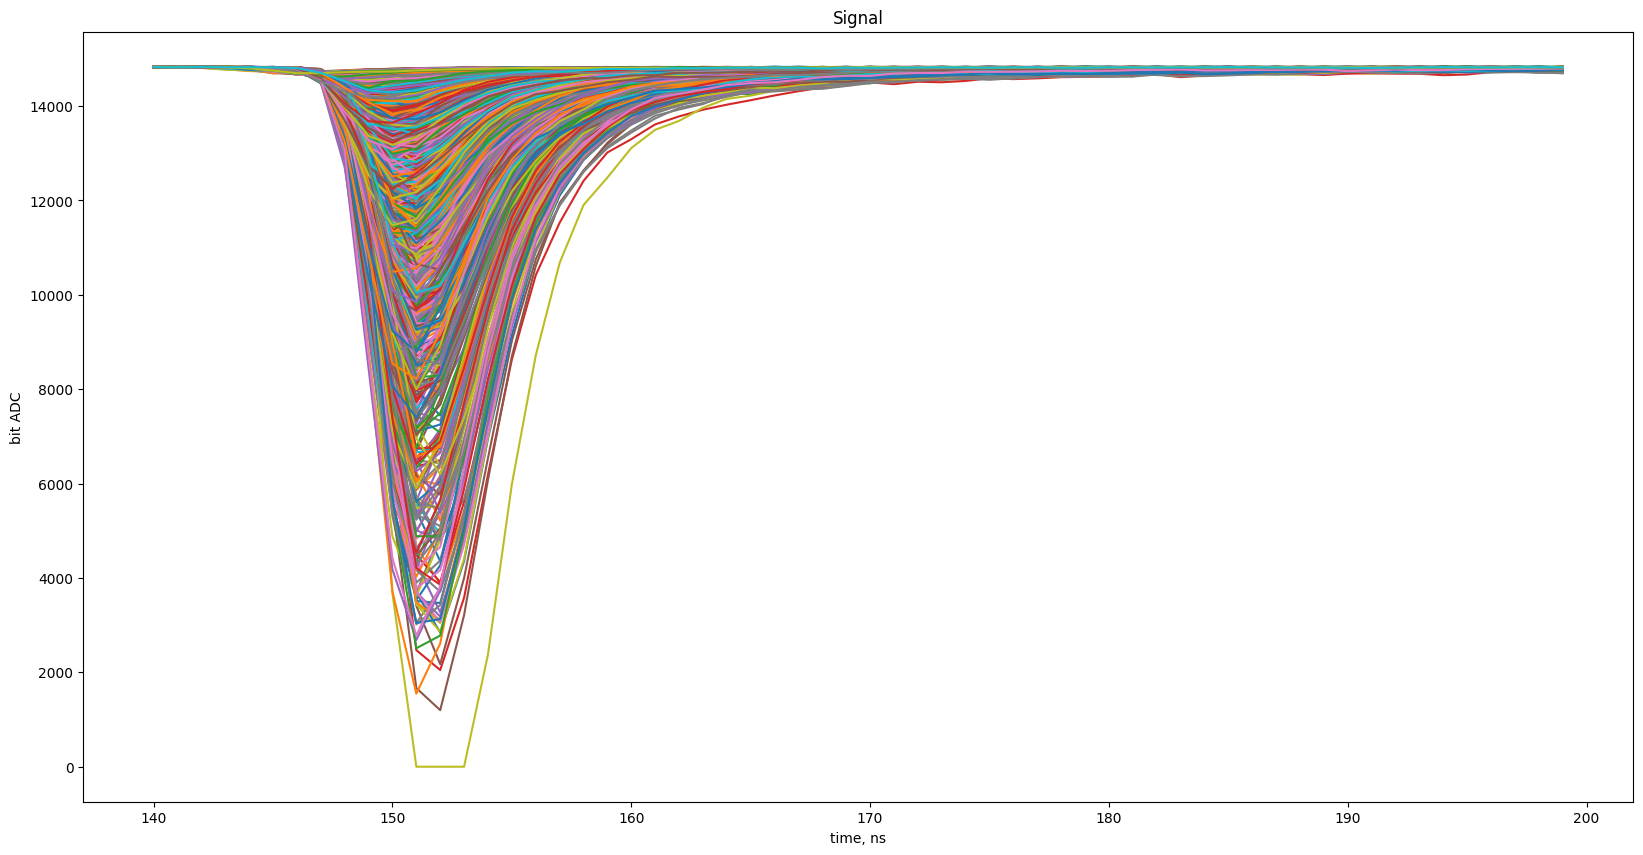

In [11]:
# Посмотрим больше сигналов, посмотрим будут ли видны выбросы
N=range(0,2000)
ax = dataset.T[N][140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

In [ ]:
# у АЦП нет данных выше точки 2**14

In [12]:
# Инвертируем для дальнейшего анализа
dataset_inv = 2**14 - dataset
dataset_inv.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1564,1561,1560,1562,1566,1564,1560,1562,1564,1564,...,1556,1562,1569,1569,1567,1565,1564,1562,1564,1565
1,1564,1562,1564,1558,1560,1562,1564,1562,1561,1563,...,1556,1567,1560,1562,1560,1565,1564,1565,1562,1564
2,1564,1564,1562,1559,1564,1560,1560,1565,1561,1560,...,1564,1563,1564,1564,1566,1563,1561,1564,1564,1563
3,1556,1562,1566,1560,1560,1562,1564,1562,1560,1564,...,1560,1558,1562,1563,1564,1556,1564,1562,1561,1562
4,1561,1569,1561,1563,1557,1564,1561,1560,1568,1563,...,1564,1564,1561,1556,1560,1564,1560,1560,1562,1559


Text(0, 0.5, 'bit ADC')

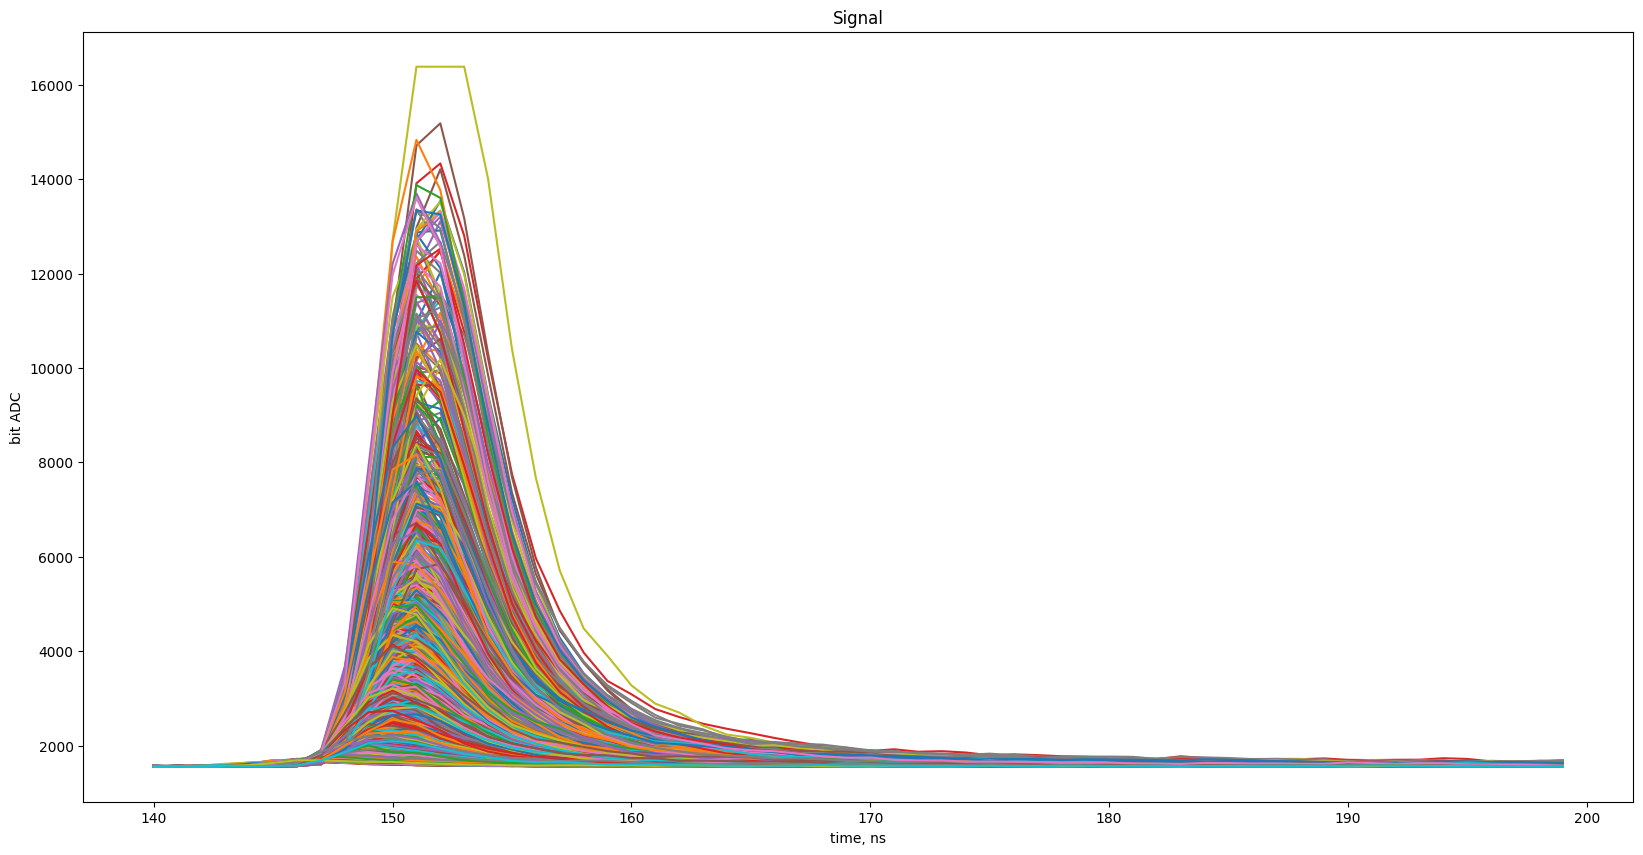

In [13]:
N=range(0,2000)
ax = dataset_inv.T[N][140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

**Вывод**

Действительное есть сигналы, которые отличаются от общей массы, такие будут относиться к кластеру 2 (не гамма-кванты и не нейтроны)

### Предобработка данных

Text(0, 0.5, 'bit ADC')

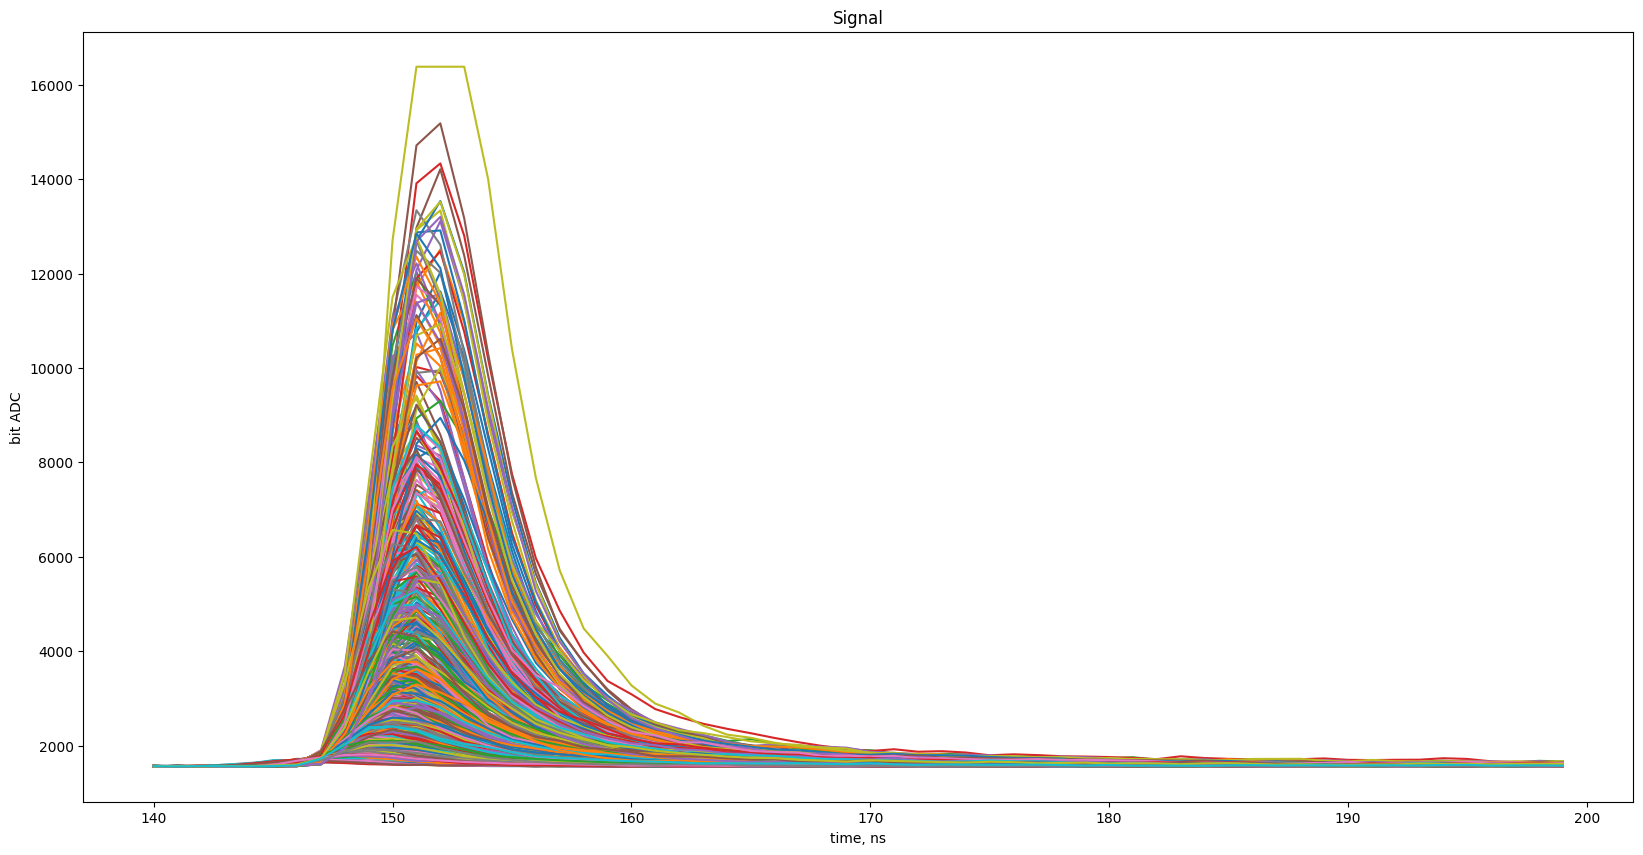

In [14]:
N=range(0,1000)
ax = dataset_inv.T[N][140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Воспользуемся формулой из методички и выделим сигналы и данные по ним: начало, конец, пик, амплитуда, площадь под кривой, нулевая линия  

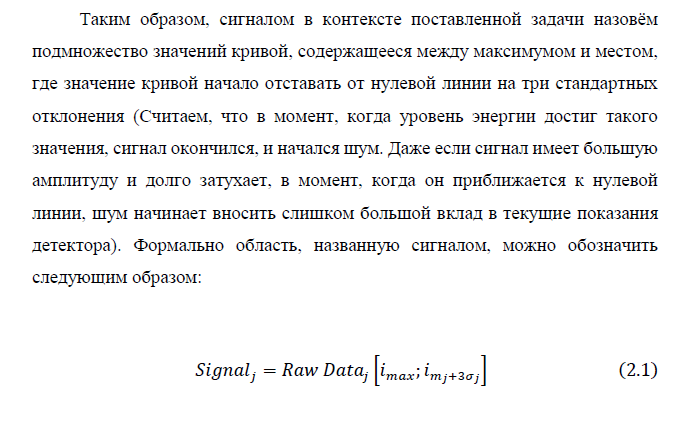

In [31]:
def get_signals(data, pre_window=140): #pre_qindow=140 выбрано исхоя из графика выше
    signals = []

    starts = []
    peak_values = []
    ends = []
    amplitudes = []
    areas = []
    baselines = []

    for row in data.itertuples(index=False):
        # Конфертируем кортеж в numpy массив
        trace = np.array(row, dtype=float)

        # нулевая линия и сигма по первым начальным точкам pre_window
        init_section = trace[:pre_window]
        baseline = np.median(init_section)
        sigma = np.std(init_section, ddof=1)

        # Находим i_max, пик соотвественно и записываем начало сигнала
        i_max = int(np.argmax(trace))
        peak_value = trace[i_max]
        i_start = min(i_max, len(trace) - 1)

        # Определяем конец сигнала по формуле
        threshold = baseline + 3.0 * sigma
        # Находим точки, которые после пика и ниже порога threshold
        post_peak = trace[i_max:]
        below_threshold = np.where(post_peak <= threshold)[0]
        # Если такие точки есть, берем первую, иначе - конец массива
        if below_threshold.size > 0:
            i_end = i_start + below_threshold[0]
        else:
            i_end = len(trace) - 1

        # вырезаем участок самого сигнала и вычитаем baseline
        signal_slice = trace[i_start:i_end+1] - baseline

        # Инвертируем, если сигнал отрицательный
        if signal_slice[0] < 0:
            sigmal_slice = -signal_slice

        # Считаем амплитуду и площадь под кривой сигнала
        amplitude  = signal_slice[0]
        area = np.trapz(signal_slice, dx=1.0)

        # Сохраняем результаты в предварительно созданные списки
        signals.append(signal_slice)
        starts.append(i_max)
        peak_values.append(peak_value)
        ends.append(i_end)
        amplitudes.append(amplitude)
        areas.append(area)
        baselines.append(baseline)

    # Создаем DataFrame
    return pd.DataFrame({
        "signal": signals,
        "start": starts,
        "peak_value": peak_values,
        "end": ends,
        "amplitude": amplitudes,
        "area": areas,
        "baseline": baselines
    }, index=data.index)

In [32]:
signals_dataset = get_signals(dataset_inv)

<ipython-input-31-8415be8ddb50>:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(signal_slice, dx=1.0)


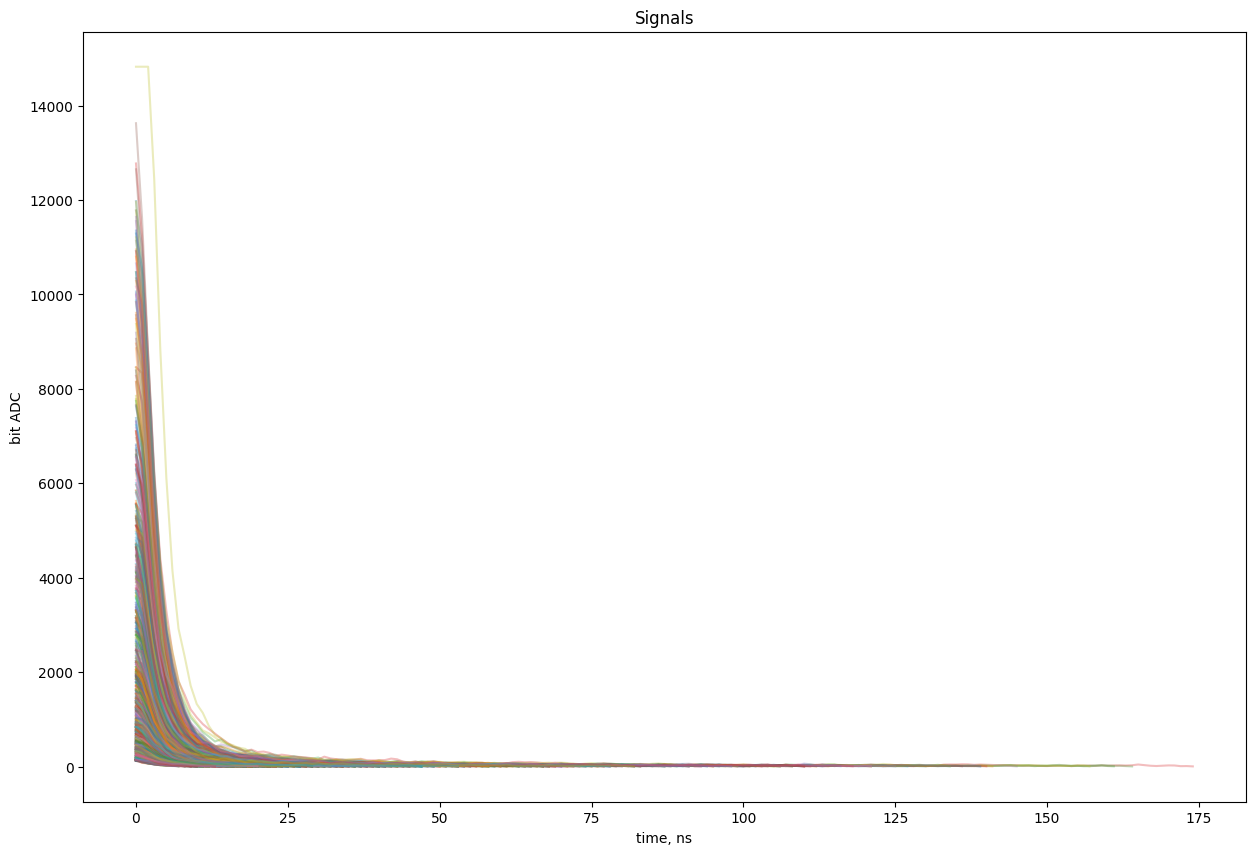

In [33]:
N = range(1000)
fig, ax = plt.subplots(figsize=(15, 10))

for idx in N:
    sig = signals_dataset.at[idx, 'signal']
    ax.plot(np.arange(len(sig)), sig, alpha=0.3)

ax.set_title('Signals')
ax.set_xlabel('time, ns')
ax.set_ylabel('bit ADC')
plt.show()

**Вывод**  
Верно выделили сигналы, согласно методичке и получили признаки, чтобы выполнить кластеризацию

In [34]:
signals_dataset

,signal,start,peak_value,end,amplitude,area,baseline
0,"[529.0, 442.0, 360.0, 288.0, 213.0, 190.0, 139...",149,2093.0,173,529.0,2552.5,1564.0
1,"[1901.5, 1783.5, 1434.5, 1070.5, 766.5, 549.5,...",150,3463.0,188,1901.5,8490.5,1561.5
2,"[2558.0, 2042.0, 1498.0, 1063.0, 720.0, 530.0,...",151,4120.0,187,2558.0,9256.5,1562.0
3,"[565.0, 526.0, 463.0, 344.0, 249.0, 187.0, 155...",149,2126.0,182,565.0,3099.0,1561.0
4,"[1793.0, 1627.0, 1323.0, 946.0, 660.0, 465.0, ...",150,3356.0,180,1793.0,7677.0,1563.0
...,...,...,...,...,...,...,...
23474,"[504.0, 491.0, 420.0, 252.0, 202.0, 177.0, 132...",149,2064.0,169,504.0,2295.0,1560.0
23475,"[5766.0, 5665.0, 4554.0, 3430.0, 2521.0, 1840....",151,7327.0,250,5766.0,32732.0,1561.0
23476,"[4998.0, 4539.0, 3551.0, 2644.0, 1887.0, 1423....",151,6559.0,278,4998.0,27968.0,1561.0
23477,"[1456.0, 1339.0, 1043.0, 783.0, 595.0, 464.0, ...",150,3017.0,205,1456.0,8144.5,1561.0


### Обучение моделе

In [36]:
# Используем standartScaler для масштабирования признаков
scaler = StandardScaler()
X_ = np.vstack((signals_dataset["area"], signals_dataset["amplitude"])).T
X = scaler.fit_transform(X_)

In [37]:
X

array([[-0.55547533, -0.54668639],
       [-0.00762249,  0.02776031],
       [ 0.06305034,  0.30253209],
       ...,
       [ 1.78941417,  1.32377067],
       [-0.0395452 , -0.15869944],
       [ 3.78606006,  3.83585017]])

In [38]:
# Для снижения размерности используем PCA, что позволит лучше отработать методы кластеризации
pca = PCA(n_components=1) # 1 компонента, т.к. разделяем на два типа сигналов + прочие не поддающиеся класстеризации
pc = pca.fit_transform(X)

In [39]:
# Используем метод класстеризции Гауссова смесь
gmm = GaussianMixture(n_components=3, random_state=0)
clusters = gmm.fit_predict(pc)

In [40]:
# Оцениваем по силуэт-скору
print(f'Silhouette Score: {silhouette_score(pc, clusters):.3f}')

Silhouette Score: 0.563


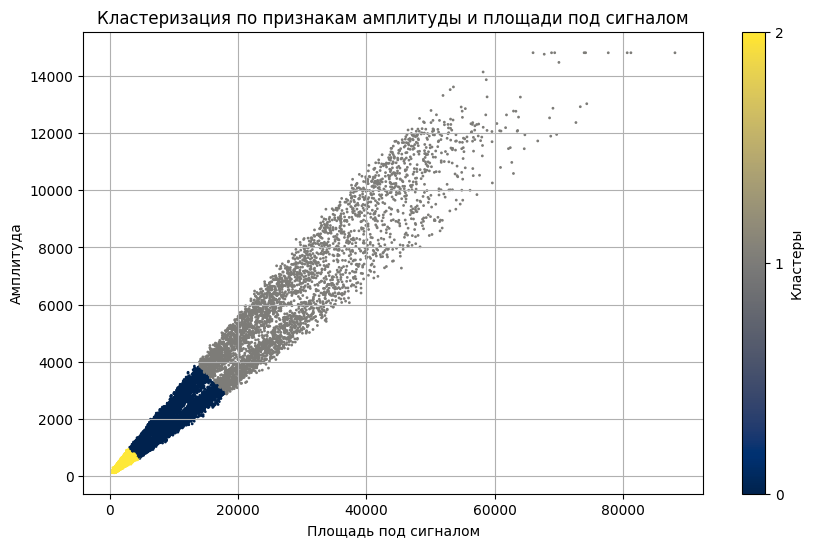

In [42]:
# Диаграмма рассеяния для зависимости амплитуды от площади под сигналом
plt.figure(figsize=(10,6))
plt.scatter(signals_dataset["area"], signals_dataset["amplitude"], c=clusters, s=1, cmap='cividis')
plt.xlabel('Площадь под сигналом')
plt.ylabel('Амплитуда')
plt.title('Кластеризация по признакам амплитуды и площади под сигналом')
plt.colorbar(label='Кластеры', ticks=[0, 1, 2])
plt.grid(True)
plt.show()

**Вывод**  
Silhouette Score выше 0.5 что показывает хорошую кластеризацию, однако на графике видно, что кластеризация выполнена неверно

In [48]:
# Выполним Future Engineering
# отношение площади к амплитуде для каждого сигнала.
signals_dataset["area/amp"] = signals_dataset["area"] / signals_dataset["amplitude"]
signals_dataset["amp/area"] = signals_dataset["amplitude"] / signals_dataset["area"] # с этим варинатом класстеризация хуже
signals_dataset.head()

,signal,start,peak_value,end,amplitude,area,baseline,area/amp,amp/area
0,"[529.0, 442.0, 360.0, 288.0, 213.0, 190.0, 139...",149,2093.0,173,529.0,2552.5,1564.0,4.825142,0.207248
1,"[1901.5, 1783.5, 1434.5, 1070.5, 766.5, 549.5,...",150,3463.0,188,1901.5,8490.5,1561.5,4.465159,0.223956
2,"[2558.0, 2042.0, 1498.0, 1063.0, 720.0, 530.0,...",151,4120.0,187,2558.0,9256.5,1562.0,3.618647,0.276346
3,"[565.0, 526.0, 463.0, 344.0, 249.0, 187.0, 155...",149,2126.0,182,565.0,3099.0,1561.0,5.484956,0.182317
4,"[1793.0, 1627.0, 1323.0, 946.0, 660.0, 465.0, ...",150,3356.0,180,1793.0,7677.0,1563.0,4.281651,0.233555


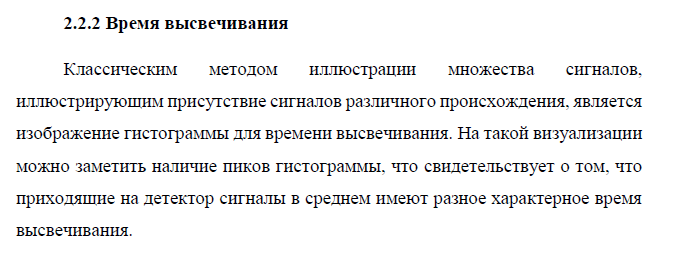

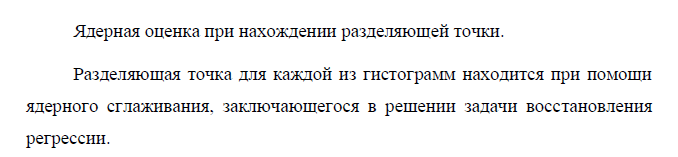

In [75]:
# Используем KDE для получения гладкой кривой вместо гистограмм (аппроксимация плотности вероятности для amp/area)
values = signals_dataset["area/amp"].values
kde = gaussian_kde(values, bw_method=0.05)
approx = np.linspace(values.min(), values.max(), 1000)
pdf = kde(approx)

In [76]:
# Находими пики и берем 2 высоких, находим минимум между ними
peaks_indices, _ = find_peaks(pdf, distance=80)
two_peaks = peaks_indices[np.argsort(pdf[peaks_indices])[-2:]]
two_peaks.sort()
min = np.argmin(pdf[two_peaks[0]:two_peaks[1]])
split = approx[two_peaks[0] + min]

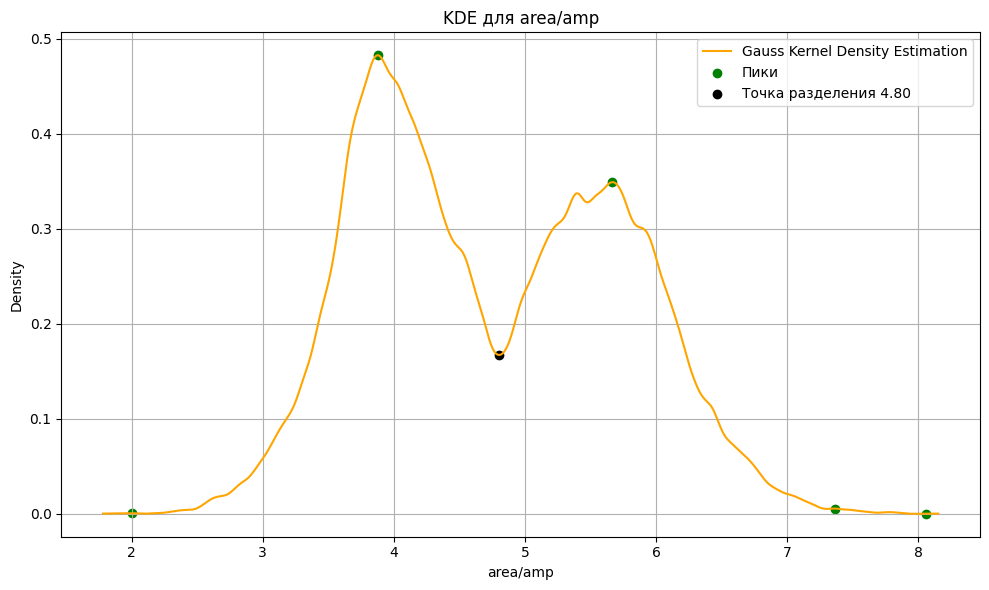

In [77]:
plt.figure(figsize=(10,6))
plt.plot(approx, pdf, color='orange', label='Gauss Kernel Density Estimation')
plt.scatter(approx[peaks_indices], pdf[peaks_indices], color='green', label='Пики')
split_y = np.interp(split, approx, pdf)
plt.scatter(split, split_y, color='black', label=f'Точка разделения {split:.2f}')
plt.xlabel('area/amp')
plt.ylabel('Density')
plt.title('KDE для area/amp')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Получили подтверждение, что сигналы разделяются на два типа происхождения, и точка разделения найдена верно.

In [78]:
# Теперь разделим сигналы на кластеры и визуализируем результат класстеризации

# Следуя методичке, у нейтронов время высвечивания больше, следовательно, а площадь под кривой больше амплитуды
# У гамма-квантов время высвечивания меньше и площадь под кривой ближе к амплитуде
# Таким образом, нейтроны выше по площади при одинаковой амплитуде, а гамма-кванты ниже по площади при одинаковой амплитуде
# Тогда если split*amplitude > area, то это гамма-квант, иначе нейтрон
# А если амплитуда очень маленькая, то относим к шуму

signals_dataset["cluster"] = np.where(
    signals_dataset["amplitude"] < 200, 2,
    np.where(signals_dataset["area"] <= split * signals_dataset["amplitude"], 0, 1)
).astype(np.int8)

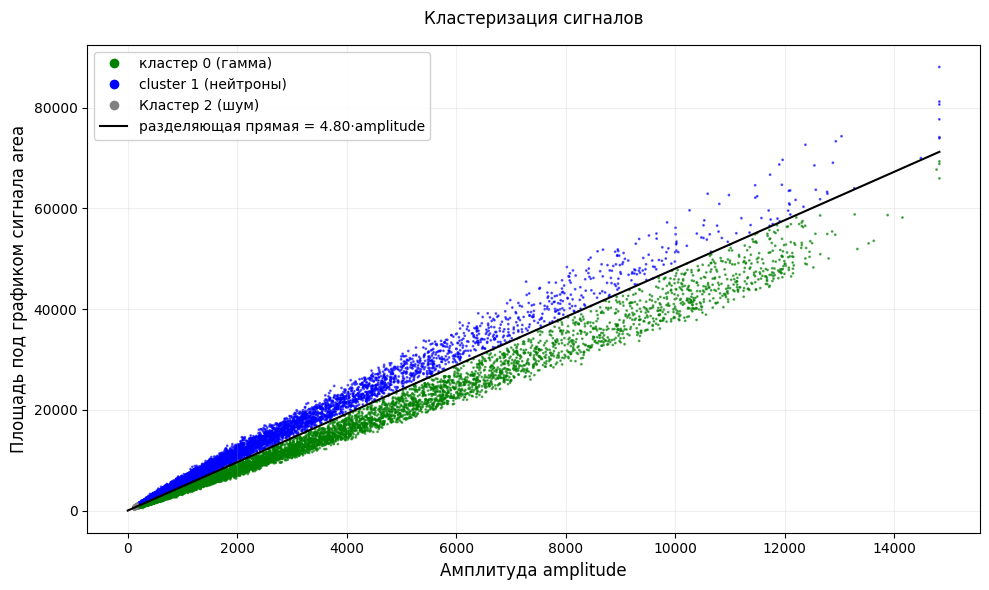

In [82]:
# Подготовка данных для визуализации
amplitude = signals_dataset["amplitude"].values
area = signals_dataset["area"].values
clusters = signals_dataset["cluster"].values

plt.figure(figsize=(10, 6), dpi=100)

# Векторизованное отображение точек
colors = np.array(["green", "blue", "gray"])
plt.scatter(amplitude, area,
            s=1, alpha=0.6,
            c=colors[clusters],  # Векторизованное назначение цветов
            label=["гамма-кванты", "нейтроны", "шум"])

# Разделяющая прямая
x_line = np.linspace(0, amplitude.max(), 100)
plt.plot(x_line, split * x_line,
         color="black", lw=1.5,
         label=f"area = {split:.3f}·amp")

# Настройки графика
plt.xlabel("Амплитуда amplitude", fontsize=12)
plt.ylabel("Площадь под графиком сигнала area", fontsize=12)
plt.title("Кластеризация сигналов", pad=15)

# Оптимизированная легенда
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[2], markersize=8),
    plt.Line2D([0], [0], color='black', lw=1.5)
]
plt.legend(handles,
           ["кластер 0 (гамма)", "cluster 1 (нейтроны)", "Кластер 2 (шум)", f"разделяющая прямая = {split:.2f}·amplitude"],
           loc='upper left',
           framealpha=0.9)

plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

In [86]:
signals_dataset["cluster"].value_counts()

,count
cluster,
0,10528
1,9679
2,3272


In [99]:
df = signals_dataset.copy()
label_mapping = {}
current_label = 0

# Проходим по датасету и фиксируем порядок появления кластеров
for cluster in signals_dataset['cluster']:
    if cluster not in label_mapping:
        label_mapping[cluster] = current_label
        current_label += 1

df['index'] = df['cluster'].map(label_mapping)

submission = df[['index']].reset_index()
submission.columns = ['index', 'cluster']
submission.to_csv('submission.csv', index=False)

In [100]:
submission

,index,cluster
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1
...,...,...
23474,23474,1
23475,23475,0
23476,23476,0
23477,23477,0


### Общие выводы к решению и интерпретация полученных результатов

В результате работы удалось кластеризовать сигналы на гамма-кванты (10528), нейтроны (9679), шум, т.е. не поддающиеся однозначной классификации (3272). Для получения результата с Silhouette Score: 0.563 был использован метод главных компонент с 1 компонентой и алгоритм Гауссовой смеси. Изначально использовались признаки: амплитуда и площадь под графиком сигнала. Однако это приводило к некачественной кластеризации. Решение было найдено с помощью добавления признака отношения данных признаков. Для проверки использвался метод gaussian KDE (Kernel Density Estimation), как было указано в методических материалах.

В данной задаче важную роль имел метод понижения размерности РСА, покольку без его использования не получилось кластеризовать сигналы.

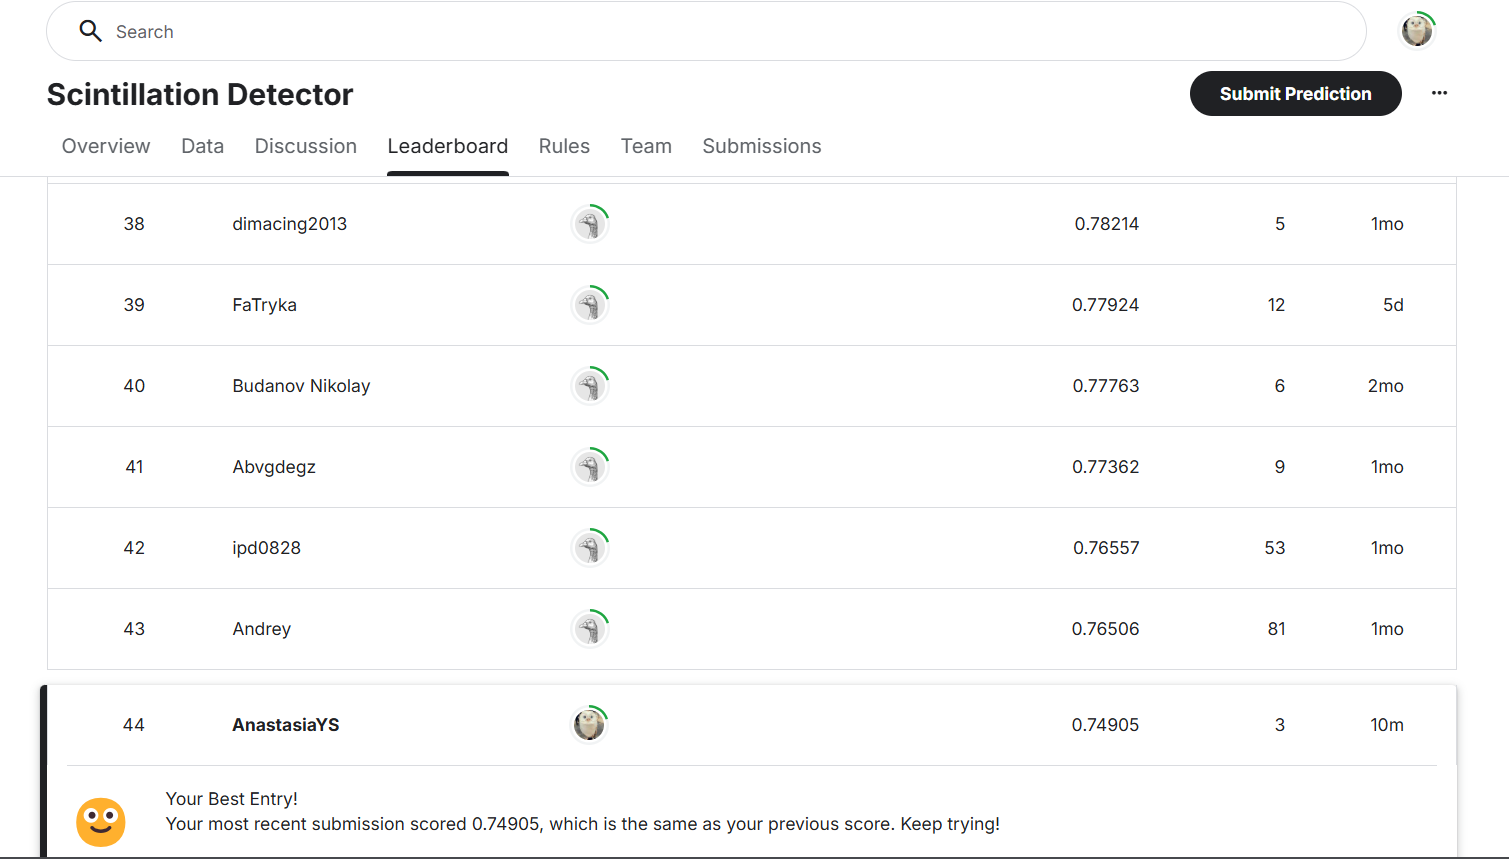